# Projeto

## Configurações Iniciais

### Bibliotecas

#### Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

#### Torch Vision

In [2]:
import torchvision
from torchvision import models
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100

##### Extras

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
%matplotlib inline

### Configurações Globais

In [4]:
torch.manual_seed(7)

### Funções Auxiliares

In [5]:
def plot_data(batch,classes,limit = 20,figsize = (10,10),n = 25, nrow = 5):
  images,labels = batch
  fig,ax = plt.subplots(figsize = figsize)
  ax.imshow(make_grid(images[:limit],nrow = 5).permute(1,2,0))
  #title = [classes[int(i)] for i in labels]
  #ax.set_title(str(title))
  print(classes[int(i)] for i in labels)
  plt.show()

In [6]:
def get_batch(dataloader):
  for batch in dataloader:
    return batch

In [7]:
def get_device():
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #print("Device: ", device)
  return device

In [8]:
def export_to_onnx(model):
  dummy_dataloader = DataLoader(torch.randn(1, 3, 32, 32),batch_size = 1)
  dummy_input = next(iter(dummy_dataloader))
  dummy_input = dummy_input.to(get_device())
  torch.onnx.export(model,dummy_input,'model.onnx')

In [9]:
def predict_image(model,image,classes = None):
  model.eval()
  image = image.to(get_device())
  output = model(image.unsqueeze(0))
  _,prediction = torch.max(output,1)
  if classes == None:
    return prediction.item()
  return classes[int(prediction.item())]

In [10]:
def predict(model,data):
  prediction = [predict_image(model,image) for image,label in data]
  return prediction

In [11]:
def fit(model,dl_train,num_epochs = 5, loss_function = nn.CrossEntropyLoss(), lr = 1e-2, optimizer = None,steps = 2000, tupla=False):
  device = get_device()
  model = model.to(device)
  if optimizer == None:
    optimizer = torch.optim.SGD(model.parameters(),lr = lr)

  model.train() # sets the model for training mode
  for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (data,targets) in enumerate(dl_train):
      data = data.to(device) # send the images to the GPU (if available)
      targets = targets.to(device) # send the labels to the GPU (if available)
      optimizer.zero_grad()

      outputs = model(data) # get the predicted results
      loss = loss_function(outputs,targets) #calculates the loss
      loss.backward() # calculates the derivative of the loss
      optimizer.step() # updates the parameters
      running_loss += loss.item()
      
      if (i+1) % steps == 0:
        print("Epoch: ", "[" + str(epoch+1) + "/" + str(num_epochs)+ "]" + ":", "Loss :", running_loss/steps, "Step:", i+1)
        running_loss = 0.0
  print('The Training is Finished')

In [12]:
def test(model,dl_test):
  device = get_device()
  correct = 0
  total = 0
  model.eval() #sets model to evaluation model (the dropout layer works differently in evaluation)
  with torch.no_grad():
    for data,labels in dl_test:
      data = data.to(device) # sends data to GPU (if available)
      labels = labels.to(device) # sends labels to GPU (if available)
      outputs = model(data) # Gets the outputs of the model
      _,predicted = torch.max(outputs.data,1) #Gets which numbers where predicted by the model
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print("Accuracy = ",correct,'/', total,(correct/total)*100,'%')

In [13]:
def plot_confusion_matrix(y_test,y_pred, classes, title = 'Confusion Matrix',figsize = (10,10), fontsize = 20,fmt = 'd'):
  cm = confusion_matrix(y_test,y_pred)
  plt.figure(figsize = figsize)
  plt.title(title,fontsize = fontsize + int(0.5*fontsize))
  s = sns.heatmap(cm, annot = True, xticklabels = classes, yticklabels = classes,fmt = fmt)
  s.set_xlabel('Predicted Label',fontsize = fontsize)
  s.set_ylabel('True Label', fontsize = fontsize)
  plt.show()

In [14]:
def show_image(image):
  plt.imshow(image.view(32,32,3))

In [15]:
def get_image(dataset):
  for image,label in dataset:
    return (image,label)

## Cifar10

### Transformações

In [ ]:
transform_train = transforms.Compose([#transforms.Resize((227,227)), 
                                     transforms.RandomHorizontalFlip(p=0.7), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.4914,0.4822,0.4465], std=[0.247,0.243,0.261])
                                     ])
transform_test = transforms.Compose([#transforms.Resize((227,227)), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.4914,0.4822,0.4465], std=[0.247,0.243,0.261])
                                    ])

In [ ]:
%cd data
!rm -rf *
%cd ..
!ls

/data
/
bin	 data	  etc	lib32  mnt   python-apt  sbin  tensorflow-1.15.2  usr
boot	 datalab  home	lib64  opt   root	 srv   tmp		  var
content  dev	  lib	media  proc  run	 sys   tools


In [ ]:
ds_train = CIFAR10('data/', train = True, download = True,transform = transform_train)
ds_test =  CIFAR10('data/', train = False, download = True, transform = transform_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
classes = ds_train.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
print(ds_train)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.7)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
           )


In [ ]:
print(ds_train.data.shape)

(50000, 32, 32, 3)


### Dataloaders

In [ ]:
batch_size = 20
dl_train = DataLoader(ds_train, batch_size = batch_size, shuffle = True)
dl_test =  DataLoader(ds_test, batch_size = batch_size, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<generator object plot_data.<locals>.<genexpr> at 0x7f7acfffe150>


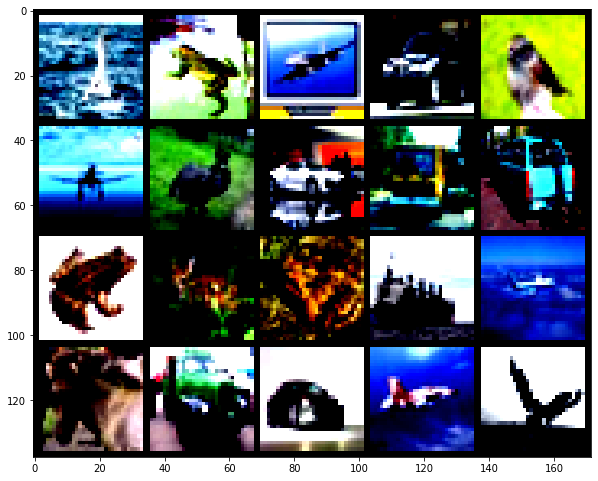

In [ ]:
batch = get_batch(dl_train)
plot_data(batch,classes)

### O Nosso Modelo Proposto

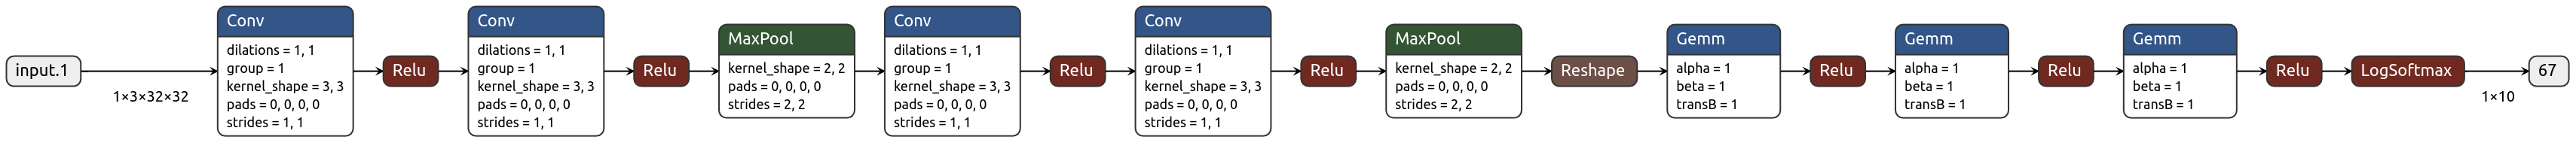

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 24, kernel_size = 3)
    self.conv1_bn = nn.BatchNorm2d(24)
    self.conv2 = nn.Conv2d(in_channels = 24, out_channels = 72, kernel_size = 3)
    self.conv2_bn = nn.BatchNorm2d(72)
    self.conv3 = nn.Conv2d(in_channels = 72, out_channels = 72, kernel_size = 3)
    self.conv3_bn = nn.BatchNorm2d(72)
    self.conv4 = nn.Conv2d(in_channels = 72, out_channels = 216, kernel_size = 3)
    self.conv4_bn = nn.BatchNorm2d(216)
    self.pool = nn.MaxPool2d(kernel_size = 2)
    self.dropout = nn.Dropout(p = 0.2)
    self.fc1 = nn.Linear(216*5*5, 600)
    self.fc1_bn = nn.BatchNorm1d(600)
    self.fc2 = nn.Linear(600,200)
    self.fc2_bn = nn.BatchNorm1d(200)
    self.fc3 = nn.Linear(200,10)
    
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.conv1_bn(x))
    x = self.conv2(x)
    x = F.relu(self.conv2_bn(x))
    x = self.pool(x)

    x = self.conv3(x)
    x = F.relu(self.conv3_bn(x))
    x = self.conv4(x)
    x = F.relu(self.conv4_bn(x))
    x = self.pool(x)

    x = x.view(-1,216*5*5)
   
    x = F.relu(self.fc1(x))
    #x = F.relu(self.fc1_bn(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    #x = self.fc2_bn(x)
    
    x = F.relu(self.fc3(x))
    return F.log_softmax(x,dim=1)

In [ ]:
model = CNN()
print(model)
model = model.to(get_device())

#### Treino

In [ ]:
fit(model,dl_train,num_epochs = 10)

Epoch:  [1/10]: Loss : 1.4634893143773078 Step: 2000


#### Test

In [ ]:
test(model,dl_test) # 10 epochs should be used at least

#### Salvando o Modelo

In [ ]:
torch.save(model,'CNN.pkl')
model = torch.load('CNN.pkl')
export_to_onnx(model)

#### Métricas de Desempenho

In [ ]:
y_pred = predict(model,ds_test)
y_test = [label for image,label in ds_test]

In [ ]:
print(classification_report(y_test,y_pred,target_names = classes))

In [ ]:
plot_confusion_matrix(y_test,y_pred,classes)

## Cifar 100

### Análise Exploratória de Dados

#### Quantidade de Imagens Por Classes

In [ ]:
%cd data
!rm -rf *
%cd ..
!ls

[Errno 2] No such file or directory: 'data'
/content
/
bin	 datalab  home	 lib64	opt	    root  srv		     tmp    var
boot	 dev	  lib	 media	proc	    run   sys		     tools
content  etc	  lib32  mnt	python-apt  sbin  tensorflow-1.15.2  usr


In [ ]:
ds_train = CIFAR100('data/', train = True, download = True,transform = transforms.ToTensor())
ds_test =  CIFAR100('data/', train = False, download = True, transform = transforms.ToTensor())

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified


##### Classes

In [ ]:
classes = ds_train.classes

In [ ]:
print(ds_train.classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

##### Dataset de Treino

In [ ]:
data = {}

for image,label in ds_train:
  if label not in data:
    data[label] = []
  data[label].append(image)

In [ ]:
qtd = [len(data[i]) for i in range(100)]

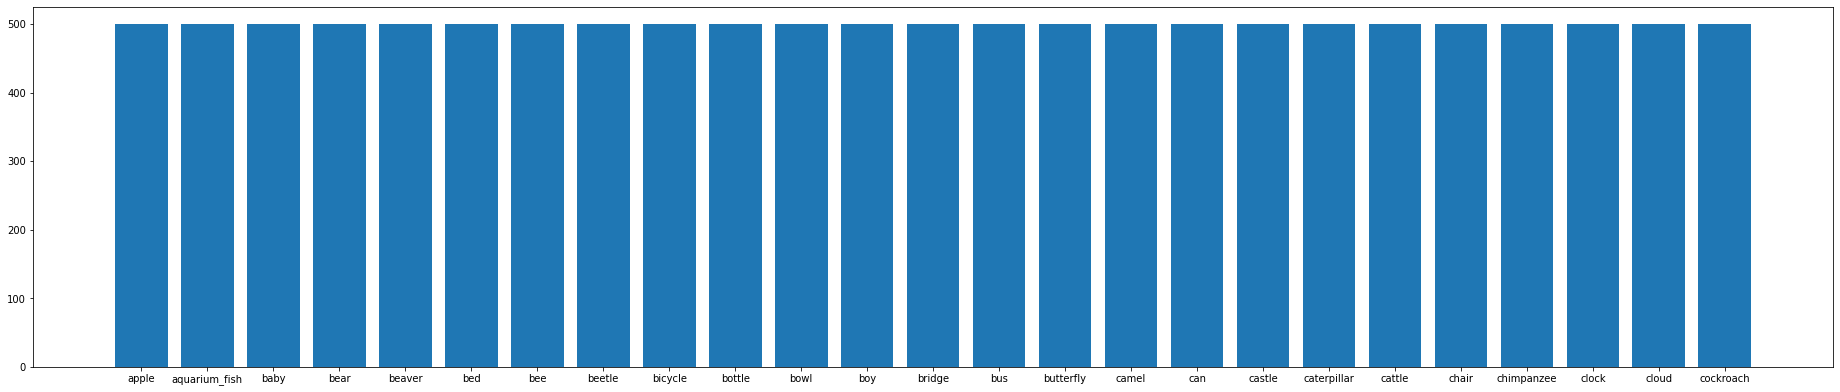

In [ ]:
fig =  plt.figure(figsize = (25,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes[0:25], qtd[0:25])
plt.show()

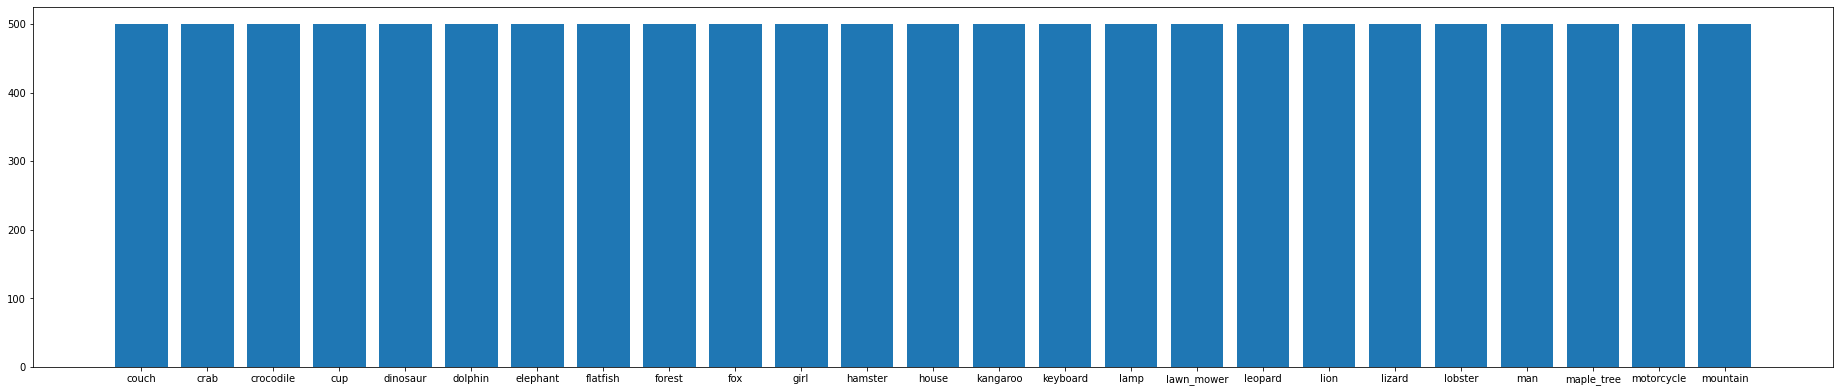

In [ ]:
fig =  plt.figure(figsize = (25,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes[25:50], qtd[25:50])
plt.show()

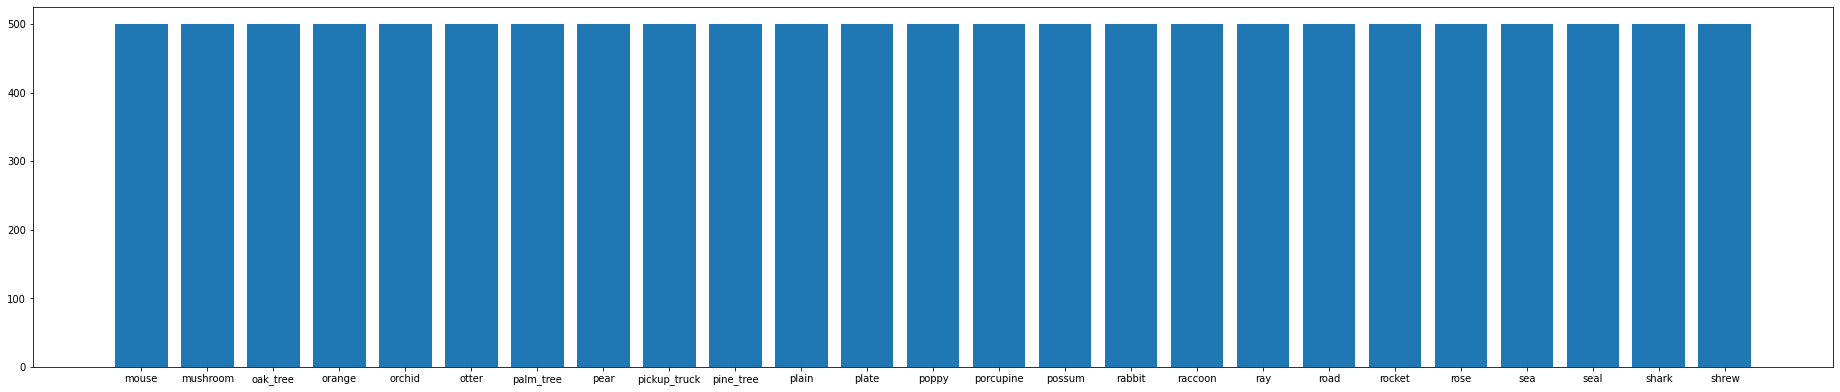

In [ ]:
fig =  plt.figure(figsize = (25,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes[50:75], qtd[50:75])
plt.show()

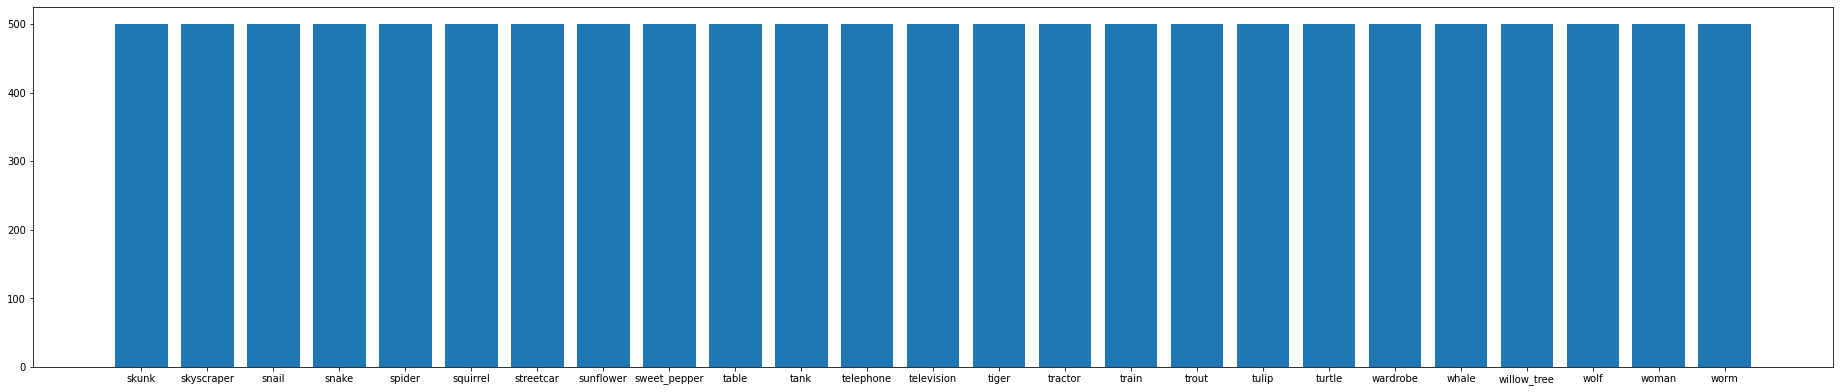

In [ ]:
fig =  plt.figure(figsize = (25,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes[75:100], qtd[75:100])
plt.show()

###### Dataset de Teste

In [ ]:
data_test = {}

for image,label in ds_test:
  if label not in data_test:
    data_test[label] = []
  data_test[label].append(image)

In [ ]:
qtd = [len(data_test[i]) for i in range(100)]

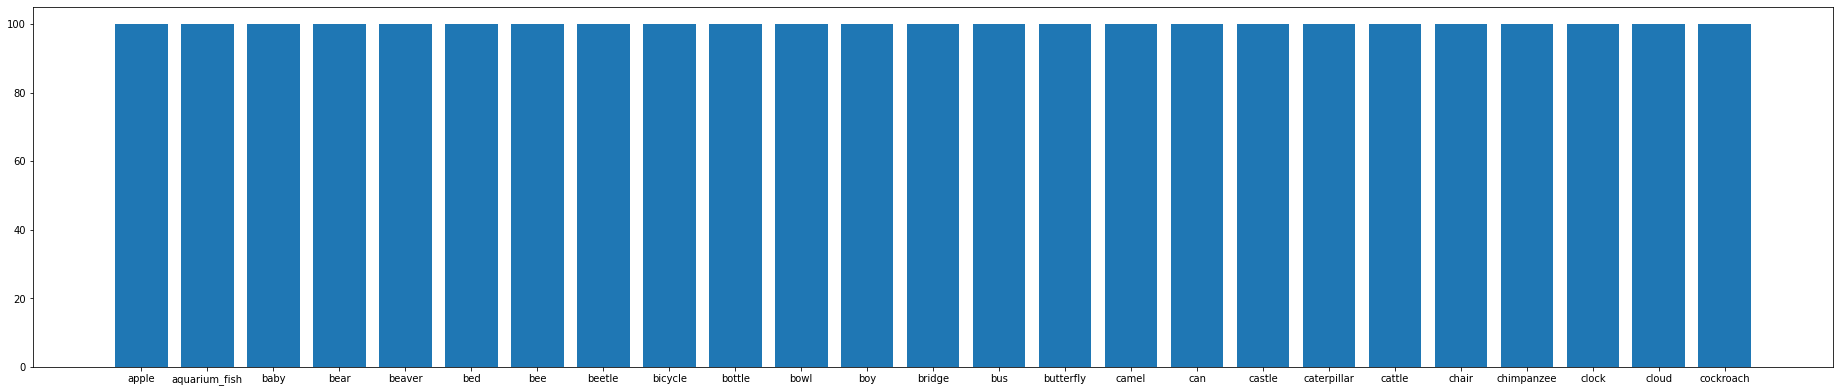

In [ ]:
fig =  plt.figure(figsize = (25,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes[0:25], qtd[0:25])
plt.show()

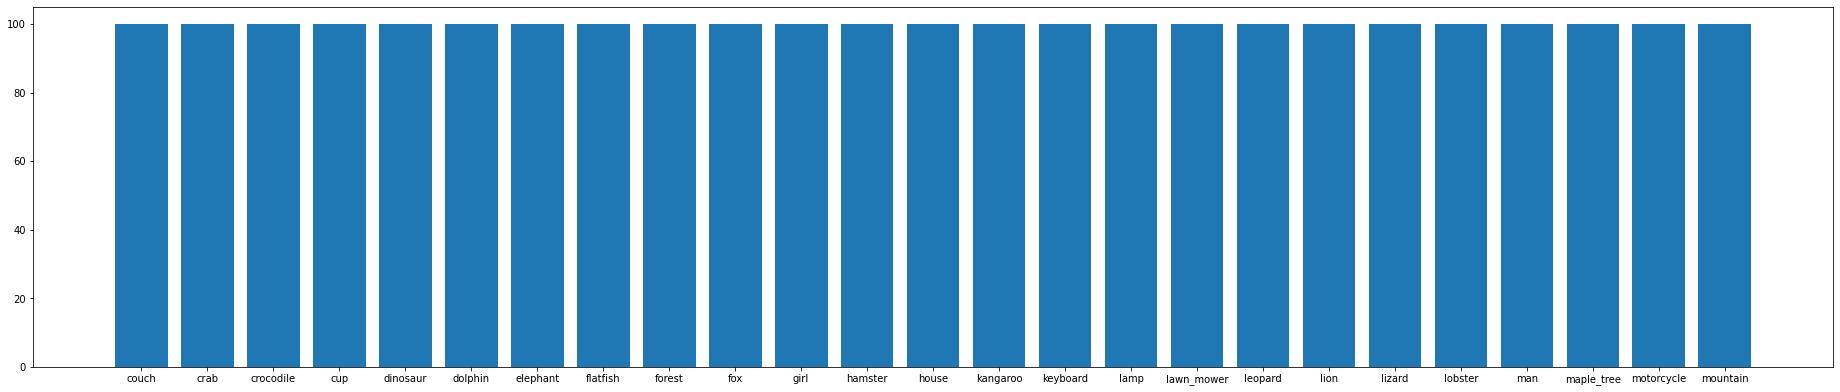

In [ ]:
fig =  plt.figure(figsize = (25,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes[25:50], qtd[25:50])
plt.show()

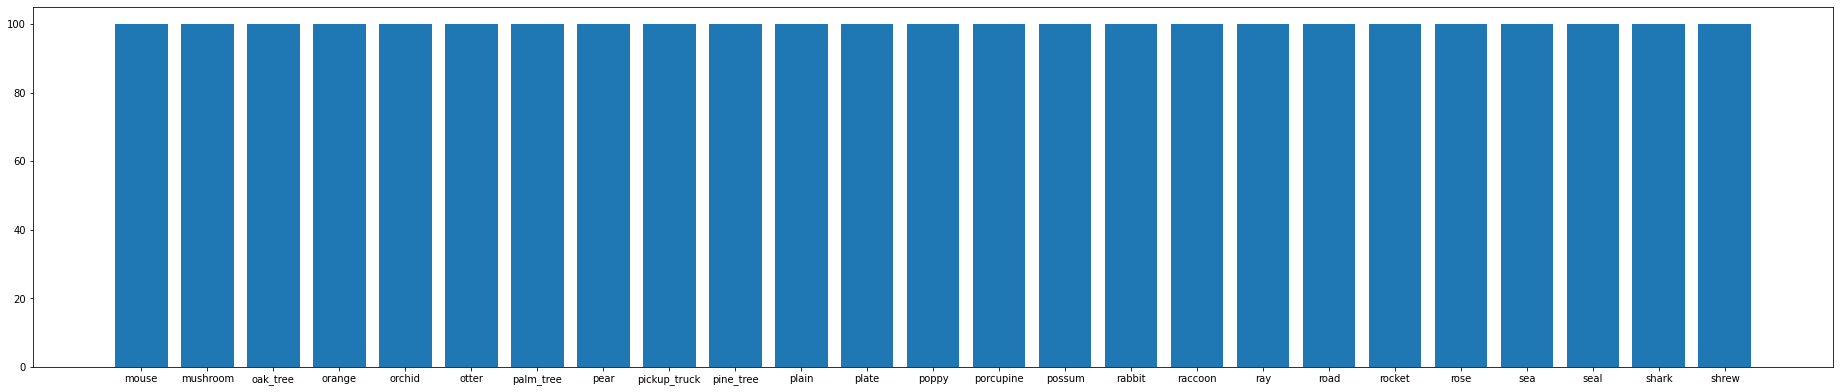

In [ ]:
fig =  plt.figure(figsize = (25,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes[50:75], qtd[50:75])
plt.show()

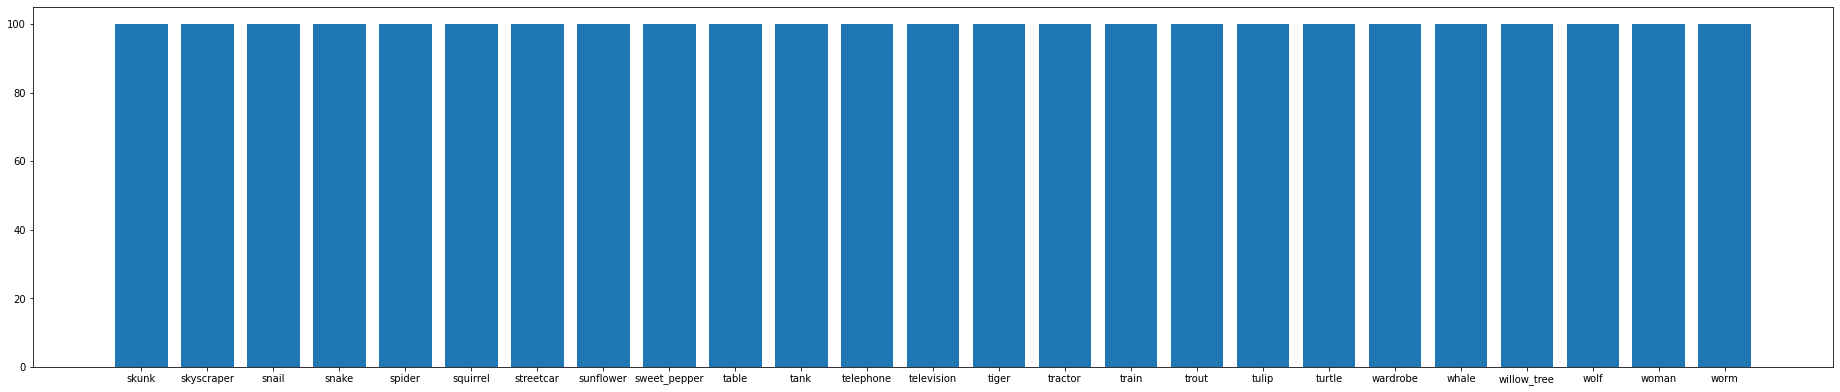

In [ ]:
fig =  plt.figure(figsize = (25,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes[75:100], qtd[75:100])
plt.show()

#### Imagens Médias

Função responsável por separar as classes em um dicionário

In [ ]:
def separate_classes(dataset): 
  data = {}
  for image,label in dataset:
    if label not in data:
      data[label] = []
    data[label].append(image)
  for key in data:
    data[key] = torch.stack(data[key])
  return data

Função responsável por calcular a imagem média de cada classe

In [ ]:
def calculate_mean(dataset):
  data = separate_classes(dataset)
  mean = {}
  for label, images in data.items():
    mean[label] = images.mean(0)
  return mean

##### Sem Normalização

In [ ]:
%cd data
!rm -rf *
%cd ..
!ls

/data
/
bin	 data	  etc	lib32  mnt   python-apt  sbin  tensorflow-1.15.2  usr
boot	 datalab  home	lib64  opt   root	 srv   tmp		  var
content  dev	  lib	media  proc  run	 sys   tools


In [ ]:
ds_train = CIFAR100('data/', train = True, download = True,transform = transforms.ToTensor())
ds_test =  CIFAR100('data/', train = False, download = True, transform = transforms.ToTensor())

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
mean = calculate_mean(ds_train)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach']


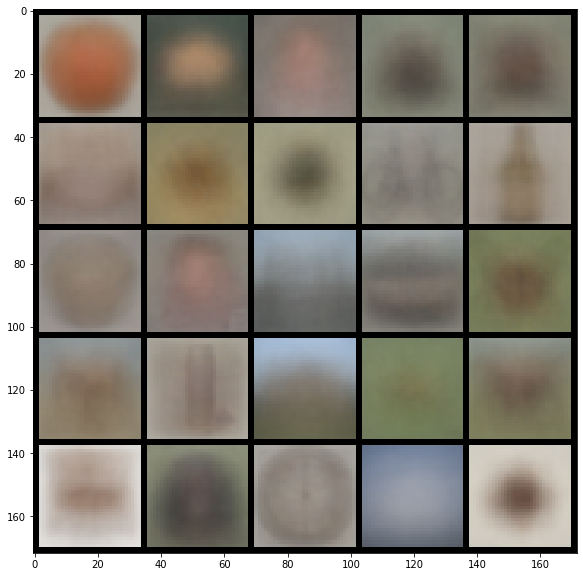

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
mean_images = [mean[i] for i in range(100)]
ax.imshow(make_grid(mean_images[0:25],nrow = 5).permute(1,2,0))
#title = [classes[int(i)] for i in range(25)]
#ax.set_title(str(title))
print([classes[int(i)] for i in range(25)])
plt.show()

['couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain']


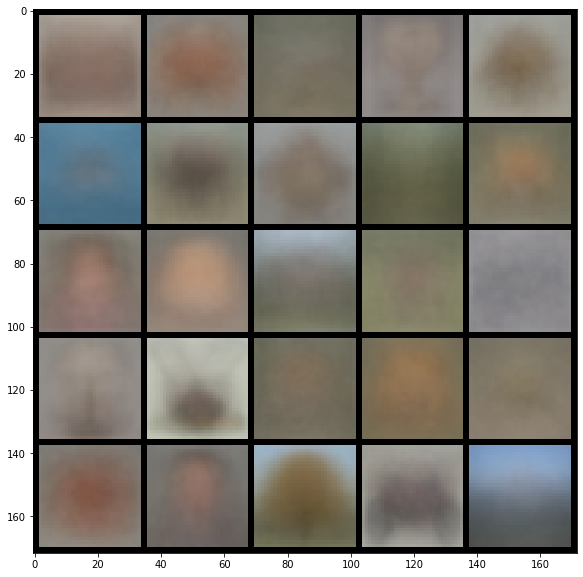

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
mean_images = [mean[i] for i in range(100)]
ax.imshow(make_grid(mean_images[25:50],nrow = 5).permute(1,2,0))
#title = [classes[i] for i in range(25,50)]
#ax.set_title(str(title))
print([classes[i] for i in range(25,50)])
plt.show()

['mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew']


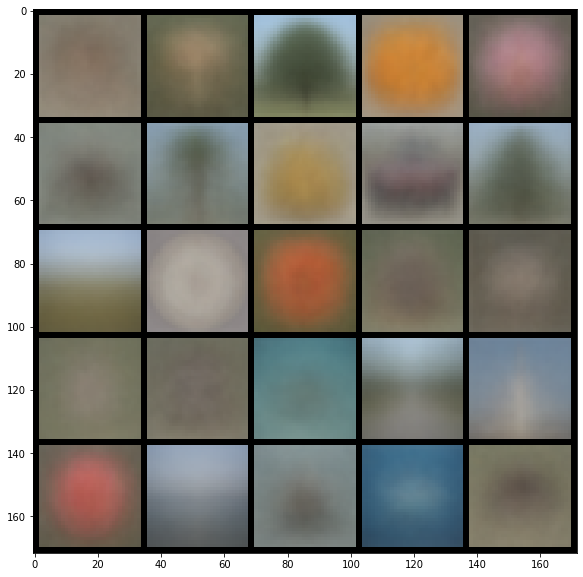

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
mean_images = [mean[i] for i in range(100)]
ax.imshow(make_grid(mean_images[50:75],nrow = 5).permute(1,2,0))
#title = [classes[i] for i in range(50,75)]
#ax.set_title(str(title))
print([classes[i] for i in range(50,75)])
plt.show()

['skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']


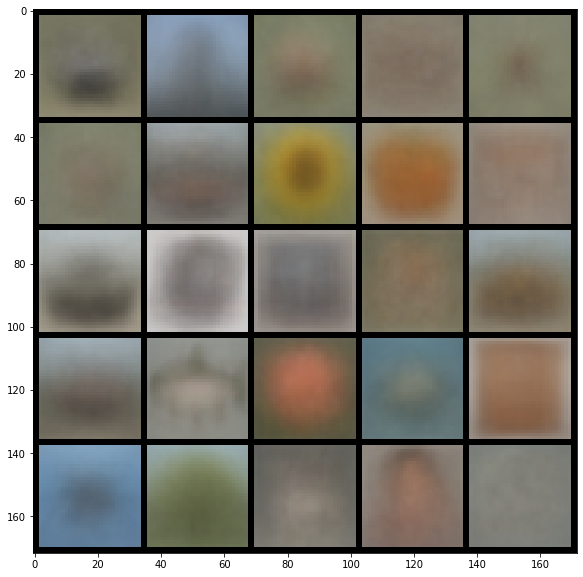

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
mean_images = [mean[i] for i in range(100)]
ax.imshow(make_grid(mean_images[75:100],nrow = 5).permute(1,2,0))
#title = [classes[i] for i in range(75,100)]
#ax.set_title(str(title))
print([classes[i] for i in range(75,100)])
plt.show()

##### Imagens Médias Normalizadas

In [ ]:
transform_train = transforms.Compose([#transforms.Resize((227,227)), 
                                     #transforms.RandomHorizontalFlip(p=0.7), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
                                     ])
transform_test = transforms.Compose([#transforms.Resize((227,227)), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
                                    ])

In [ ]:
%cd data
!rm -rf *
%cd ..
!ls

/data
/
bin	 data	  etc	lib32  mnt   python-apt  sbin  tensorflow-1.15.2  usr
boot	 datalab  home	lib64  opt   root	 srv   tmp		  var
content  dev	  lib	media  proc  run	 sys   tools


In [ ]:
ds_train = CIFAR100('data/', train = True, download = True,transform = transform_train)
ds_test =  CIFAR100('data/', train = False, download = True, transform = transform_test)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
mean = calculate_mean(ds_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach']


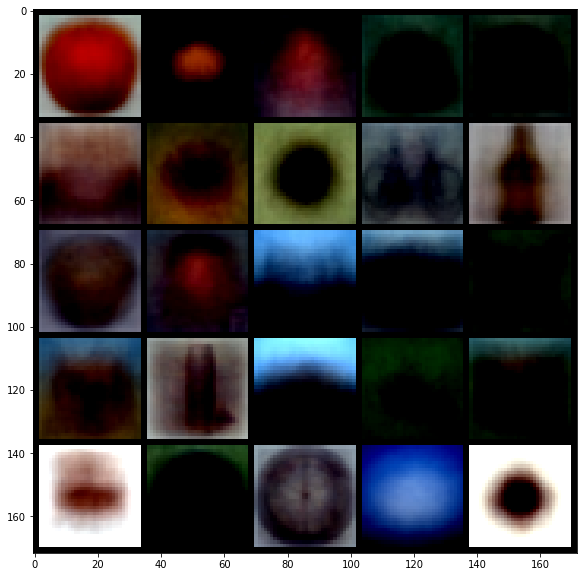

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
mean_images = [mean[i] for i in range(100)]
ax.imshow(make_grid(mean_images[0:25],nrow = 5).permute(1,2,0))
#title = [classes[int(i)] for i in range(25)]
#ax.set_title(str(title))
print([classes[int(i)] for i in range(25)])
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain']


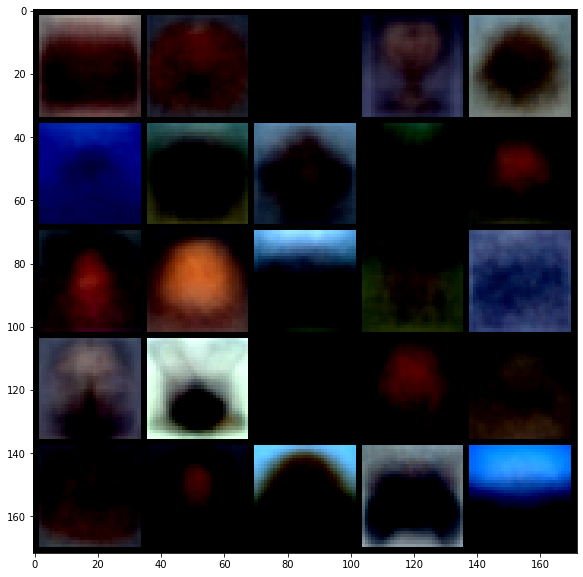

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
mean_images = [mean[i] for i in range(100)]
ax.imshow(make_grid(mean_images[25:50],nrow = 5).permute(1,2,0))
#title = [classes[i] for i in range(25,50)]
#ax.set_title(str(title))
print([classes[i] for i in range(25,50)])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew']


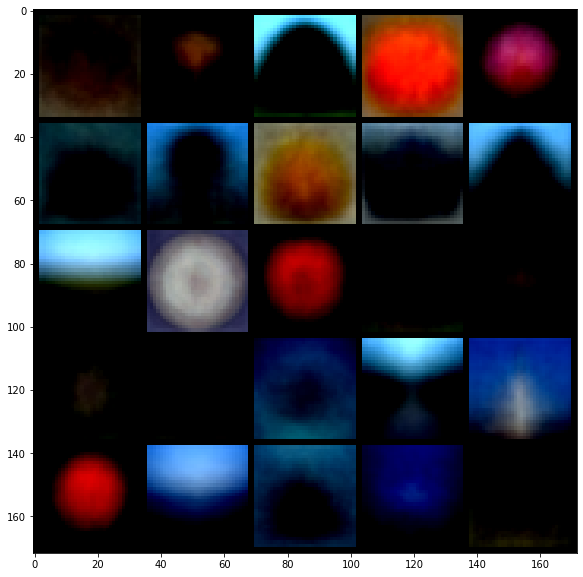

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
mean_images = [mean[i] for i in range(100)]
ax.imshow(make_grid(mean_images[50:75],nrow = 5).permute(1,2,0))
#title = [classes[i] for i in range(50,75)]
#ax.set_title(str(title))
print([classes[i] for i in range(50,75)])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']


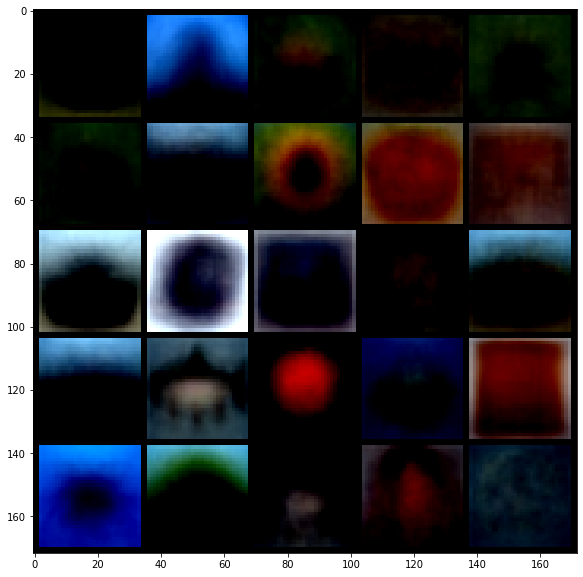

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
mean_images = [mean[i] for i in range(100)]
ax.imshow(make_grid(mean_images[75:100],nrow = 5).permute(1,2,0))
#title = [classes[i] for i in range(75,100)]
#ax.set_title(str(title))
print([classes[i] for i in range(75,100)])
plt.show()

### Experimentos

#### Pixel Similarity

Baseado na abordagem do [fastai](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb), iremos criar um modelo básico que não utiliza aprendizado de máquina, para ter uma precisão como base para verificar o desempenho dos próximos modelos. Esse método basicamente cálcula uma imagem média para cada classe do conjunto de treino, esta imagem média é basicamente uma imagem formada pela média de cada pixel das imagens de uma classe.

Para fazer a predição esta arquitetura basicamente cálcula a distância de uma imagem a imagem média, e escolhe a classe com a menor distância

Podemos usar o erro quadrático médio ou o valor absoluto das diferenças como valor da distância total entre uma imagem e a média da sua classe

In [ ]:
def distance(image,mean,dist):
  if dist == 'mse':
      return torch.tensor([((image - mean[i])**2).mean().sqrt() for i in range(100)])
  elif dist == 'abs':
      return torch.tensor([(image - mean[i]).abs().mean() for i in range(100)])
  return None

E escolher a classe que possui a menor distância

In [ ]:
def simple_predict(image,mean,dist):
  dist = distance(image,mean,dist)
  min_index = 0 
  for i in range(1,100):
    if dist[i] < dist[i]:
      min_index = i
  return min_index


In [ ]:
def simple_predict_all(ds_test,mean,dist):
  prediction = []
  for image,label in ds_test:
    prediction.append(simple_predict(image,mean,dist))
  return prediction

In [ ]:
y_true = [label for image, label in ds_test]
y_pred = simple_predict_all(ds_test, mean,'abs')

In [ ]:
print(classification_report(y_true,y_pred,target_names = classes))

               precision    recall  f1-score   support

        apple       0.01      1.00      0.02       100
aquarium_fish       0.00      0.00      0.00       100
         baby       0.00      0.00      0.00       100
         bear       0.00      0.00      0.00       100
       beaver       0.00      0.00      0.00       100
          bed       0.00      0.00      0.00       100
          bee       0.00      0.00      0.00       100
       beetle       0.00      0.00      0.00       100
      bicycle       0.00      0.00      0.00       100
       bottle       0.00      0.00      0.00       100
         bowl       0.00      0.00      0.00       100
          boy       0.00      0.00      0.00       100
       bridge       0.00      0.00      0.00       100
          bus       0.00      0.00      0.00       100
    butterfly       0.00      0.00      0.00       100
        camel       0.00      0.00      0.00       100
          can       0.00      0.00      0.00       100
       ca

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_true = [label for image, label in ds_test]
y_pred = simple_predict_all(ds_test, mean,'mse')

In [ ]:
print(classification_report(y_true,y_pred,target_names = classes))

               precision    recall  f1-score   support

        apple       0.01      1.00      0.02       100
aquarium_fish       0.00      0.00      0.00       100
         baby       0.00      0.00      0.00       100
         bear       0.00      0.00      0.00       100
       beaver       0.00      0.00      0.00       100
          bed       0.00      0.00      0.00       100
          bee       0.00      0.00      0.00       100
       beetle       0.00      0.00      0.00       100
      bicycle       0.00      0.00      0.00       100
       bottle       0.00      0.00      0.00       100
         bowl       0.00      0.00      0.00       100
          boy       0.00      0.00      0.00       100
       bridge       0.00      0.00      0.00       100
          bus       0.00      0.00      0.00       100
    butterfly       0.00      0.00      0.00       100
        camel       0.00      0.00      0.00       100
          can       0.00      0.00      0.00       100
       ca

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ao contrário da abordagem original do fastai para o dataset mnist com apenas duas classe, que teve uma 'accuracy' extremamente alta com este método, temos que a 'accuracy' que tivemos com o CIFAR 100 que possui muito mais classes, e imagens coloridas, não é melhor do que selecionarmos uma classe ao acaso

#### Treinando os Modelos

##### Dataset

In [96]:
transform_train = transforms.Compose([#transforms.Resize((227,227)), 
                                     transforms.RandomHorizontalFlip(p=0.7), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
                                     ])
transform_test = transforms.Compose([#transforms.Resize((227,227)), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
                                    ])

In [97]:
%cd data
!rm -rf *
%cd ..
!ls

/data
/
alexnet0.pkl	 cnn_l.pkl  lenet0.pkl	   mnt	       sys
alexnet_1ep.pkl  cnn.pkl    lenet_1ep.pkl  opt	       tensorflow-1.15.2
alexnet_l.pkl	 content    lenet_l.pkl    proc        tmp
alexnet.pkl	 data	    lenet.pkl	   python-apt  tools
bin		 datalab    lib		   root        usr
boot		 dev	    lib32	   run	       var
cnn0.pkl	 etc	    lib64	   sbin
cnn_1ep.pkl	 home	    media	   srv


In [98]:
ds_train = CIFAR100('data/', train = True, download = True,transform = transform_train)
ds_test =  CIFAR100('data/', train = False, download = True, transform = transform_test)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified


In [99]:
classes = ds_train.classes

In [100]:
ds_train.data.shape

(50000, 32, 32, 3)

##### Dataloaders

In [101]:
batch_size = 40
dl_train = DataLoader(ds_train, batch_size = batch_size, shuffle = True)
dl_test =  DataLoader(ds_test, batch_size = batch_size, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<generator object plot_data.<locals>.<genexpr> at 0x7f40dcf9bf50>


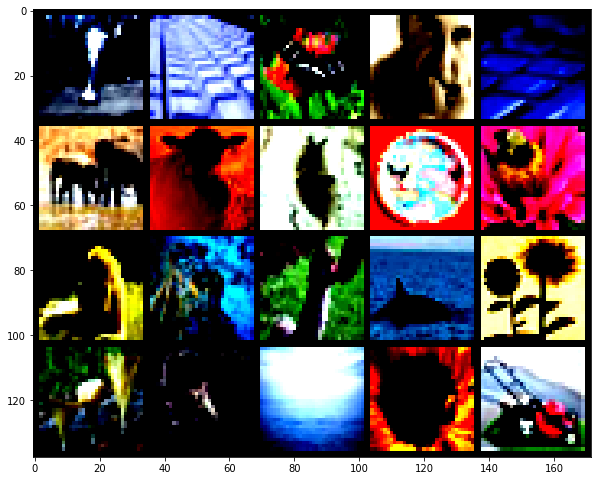

In [102]:
batch = get_batch(dl_train)
plot_data(batch,classes)

##### Modelos

###### O Modelo Proposto por Nós

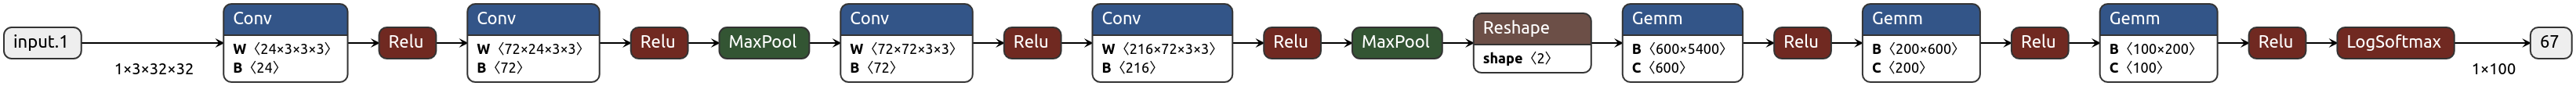

In [23]:
class CNN100(nn.Module):
  def __init__(self):
    super(CNN100,self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 24, kernel_size = 3)
    self.conv1_bn = nn.BatchNorm2d(24)
    self.conv2 = nn.Conv2d(in_channels = 24, out_channels = 72, kernel_size = 3)
    self.conv2_bn = nn.BatchNorm2d(72)
    self.conv3 = nn.Conv2d(in_channels = 72, out_channels = 72, kernel_size = 3)
    self.conv3_bn = nn.BatchNorm2d(72)
    self.conv4 = nn.Conv2d(in_channels = 72, out_channels = 216, kernel_size = 3)
    self.conv4_bn = nn.BatchNorm2d(216)
    self.pool = nn.MaxPool2d(kernel_size = 2)
    self.dropout = nn.Dropout(p = 0.2)
    self.fc1 = nn.Linear(216*5*5, 600)
    self.fc1_bn = nn.BatchNorm1d(600)
    self.fc2 = nn.Linear(600,200)
    self.fc2_bn = nn.BatchNorm1d(200)
    self.fc3 = nn.Linear(200,100)
    
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.conv1_bn(x))
    x = self.conv2(x)
    x = F.relu(self.conv2_bn(x))
    x = self.pool(x)

    x = self.conv3(x)
    x = F.relu(self.conv3_bn(x))
    x = self.conv4(x)
    x = F.relu(self.conv4_bn(x))
    x = self.pool(x)

    x = x.view(-1,216*5*5)
   
    x = F.relu(self.fc1(x))
    #x = F.relu(self.fc1_bn(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    #x = self.fc2_bn(x)
    
    x = self.fc3(x)
    return F.log_softmax(x,dim=1)

In [24]:
cnn = CNN100()
cnn = cnn.to(get_device())
torch.save(cnn,'cnn0.pkl')
print(cnn)

CNN100(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(24, 72, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(72, 216, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=5400, out_features=600, bias=True)
  (fc1_bn): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc2_bn): BatchNorm1d(2

###### LeNet (Modificado)

In [25]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=2)
    self.avgPool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(576, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 100)
    
  def forward(self, x):
    x = F.sigmoid(self.conv1(x))
    x = self.avgPool(x)
    x = F.sigmoid(self.conv2(x))
    x = self.avgPool(x)
    x = self.flatten(x)
    x = F.sigmoid(self.fc1(x))
    x = F.sigmoid(self.fc2(x))
    x = self.fc3(x)
    #print(x.shape)
    return x


In [26]:
lenet = LeNet()
lenet = lenet.to(get_device())
torch.save(lenet,'lenet0.pkl')
print(lenet)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (avgPool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)


###### AlexNet (Modificado)

In [27]:
class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet,self).__init__()
    self.conv1 = nn.Conv2d(3, 96, kernel_size=11, padding=1)
    self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
    self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
    self.dropout = nn.Dropout(p=0.5)
    self.fc1 = nn.Linear(256*2*2, 4096) 
    self.fc2 = nn.Linear(4096, 4096)
    self.fc3 = nn.Linear(4096, 100)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)

    x = F.relu(self.conv2(x))
    x = self.pool(x)
    
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = self.pool(x)
    #print(x.shape)
    x = x.view(-1,256*2*2)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)

    return x



In [28]:
alexnet = AlexNet()
alexnet = alexnet.to(get_device())
torch.save(alexnet,'alexnet0.pkl')
print(alexnet)

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=100, bias=True)
)


##### Treino

In [29]:
num_epochs = 50

###### Nosso Modelo

In [30]:
fit(cnn,dl_train,num_epochs = num_epochs,steps = 1000)

Epoch:  [1/50]: Loss : 4.221396705627441 Step: 1000
Epoch:  [2/50]: Loss : 3.442529371023178 Step: 1000
Epoch:  [3/50]: Loss : 3.016068526506424 Step: 1000
Epoch:  [4/50]: Loss : 2.726536409974098 Step: 1000
Epoch:  [5/50]: Loss : 2.5214961433410643 Step: 1000
Epoch:  [6/50]: Loss : 2.3667297565937044 Step: 1000
Epoch:  [7/50]: Loss : 2.2413606016635894 Step: 1000
Epoch:  [8/50]: Loss : 2.131696190714836 Step: 1000
Epoch:  [9/50]: Loss : 2.045403267621994 Step: 1000
Epoch:  [10/50]: Loss : 1.9596656314134597 Step: 1000
Epoch:  [11/50]: Loss : 1.8683195123672485 Step: 1000
Epoch:  [12/50]: Loss : 1.8028394047021865 Step: 1000
Epoch:  [13/50]: Loss : 1.7309640917778015 Step: 1000
Epoch:  [14/50]: Loss : 1.672695976316929 Step: 1000
Epoch:  [15/50]: Loss : 1.6129718722701072 Step: 1000
Epoch:  [16/50]: Loss : 1.549377133488655 Step: 1000
Epoch:  [17/50]: Loss : 1.5024642004966735 Step: 1000
Epoch:  [18/50]: Loss : 1.443586164832115 Step: 1000
Epoch:  [19/50]: Loss : 1.3880341518521309 Ste

In [32]:
torch.save(cnn,'cnn.pkl')

###### LeNet

In [33]:
fit(lenet,dl_train,num_epochs = num_epochs,steps = 1000)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  [1/50]: Loss : 4.610275352478028 Step: 1000
Epoch:  [2/50]: Loss : 4.60709143781662 Step: 1000
Epoch:  [3/50]: Loss : 4.607117957592011 Step: 1000
Epoch:  [4/50]: Loss : 4.607108925819397 Step: 1000
Epoch:  [5/50]: Loss : 4.607210103034973 Step: 1000
Epoch:  [6/50]: Loss : 4.607090084075928 Step: 1000
Epoch:  [7/50]: Loss : 4.607166917800903 Step: 1000
Epoch:  [8/50]: Loss : 4.606955875873566 Step: 1000
Epoch:  [9/50]: Loss : 4.607037053585053 Step: 1000
Epoch:  [10/50]: Loss : 4.606995623588562 Step: 1000
Epoch:  [11/50]: Loss : 4.606891127109527 Step: 1000
Epoch:  [12/50]: Loss : 4.607133620738983 Step: 1000
Epoch:  [13/50]: Loss : 4.606977580070495 Step: 1000
Epoch:  [14/50]: Loss : 4.606872906684876 Step: 1000
Epoch:  [15/50]: Loss : 4.606975681304932 Step: 1000
Epoch:  [16/50]: Loss : 4.606828499794006 Step: 1000
Epoch:  [17/50]: Loss : 4.606954144954681 Step: 1000
Epoch:  [18/50]: Loss : 4.60695934677124 Step: 1000
Epoch:  [19/50]: Loss : 4.6069412140846255 Step: 1000
Epo

In [34]:
torch.save(lenet,'lenet.pkl')

###### AlexNet

In [38]:
fit(alexnet,dl_train,num_epochs = num_epochs,steps = 1000)

Epoch:  [1/50]: Loss : 4.605053863048553 Step: 1000
Epoch:  [2/50]: Loss : 4.603819807529449 Step: 1000
Epoch:  [3/50]: Loss : 4.554995917797089 Step: 1000
Epoch:  [4/50]: Loss : 4.223932805538177 Step: 1000
Epoch:  [5/50]: Loss : 4.054544434785843 Step: 1000
Epoch:  [6/50]: Loss : 3.8857276592254637 Step: 1000
Epoch:  [7/50]: Loss : 3.7299574971199037 Step: 1000
Epoch:  [8/50]: Loss : 3.5947757971286776 Step: 1000
Epoch:  [9/50]: Loss : 3.465284445285797 Step: 1000
Epoch:  [10/50]: Loss : 3.3228505601882934 Step: 1000
Epoch:  [11/50]: Loss : 3.193504056215286 Step: 1000
Epoch:  [12/50]: Loss : 3.049126019239426 Step: 1000
Epoch:  [13/50]: Loss : 2.941783545255661 Step: 1000
Epoch:  [14/50]: Loss : 2.8360857899188994 Step: 1000
Epoch:  [15/50]: Loss : 2.7406764866113664 Step: 1000
Epoch:  [16/50]: Loss : 2.645433095216751 Step: 1000
Epoch:  [17/50]: Loss : 2.5626494125127794 Step: 1000
Epoch:  [18/50]: Loss : 2.481579114317894 Step: 1000
Epoch:  [19/50]: Loss : 2.406880156636238 Step: 

In [39]:
torch.save(alexnet,'alexnet.pkl')

##### Salvando os Modelos

In [45]:
torch.save(cnn,'cnn.pkl')
torch.save(lenet,'lenet.pkl')
torch.save(alexnet,'alexnet.pkl')

#export_to_onnx(model,num_epochs = 1,steps = 500)

##### Test

###### Carregando os Modelos

In [40]:
cnn = torch.load('cnn.pkl')
lenet = torch.load('lenet.pkl')
alexnet = torch.load('alexnet.pkl')

###### Nosso Modelo

In [36]:
test(cnn,dl_test) 

Accuracy =  5520 / 10000 55.2 %


###### LeNet

In [37]:
test(lenet,dl_test)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy =  100 / 10000 1.0 %


###### AlexNet

In [41]:
test(alexnet,dl_test)

Accuracy =  4906 / 10000 49.059999999999995 %


##### Métricas de Desempenho

###### Nosso Modelo

In [42]:
y_pred = predict(cnn,ds_test)
y_test = [label for image,label in ds_test]
print(classification_report(y_test,y_pred,target_names = classes))

               precision    recall  f1-score   support

        apple       0.78      0.77      0.77       100
aquarium_fish       0.67      0.71      0.69       100
         baby       0.42      0.42      0.42       100
         bear       0.46      0.22      0.30       100
       beaver       0.32      0.40      0.36       100
          bed       0.36      0.55      0.43       100
          bee       0.62      0.66      0.64       100
       beetle       0.54      0.66      0.59       100
      bicycle       0.79      0.76      0.78       100
       bottle       0.54      0.74      0.62       100
         bowl       0.48      0.32      0.38       100
          boy       0.50      0.34      0.40       100
       bridge       0.56      0.60      0.58       100
          bus       0.51      0.53      0.52       100
    butterfly       0.57      0.54      0.55       100
        camel       0.34      0.59      0.43       100
          can       0.64      0.55      0.59       100
       ca

###### LeNet

In [43]:
y_pred = predict(lenet,ds_test)
y_test = [label for image,label in ds_test]
print(classification_report(y_test,y_pred,target_names = classes))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


               precision    recall  f1-score   support

        apple       0.00      0.00      0.00       100
aquarium_fish       0.00      0.00      0.00       100
         baby       0.00      0.00      0.00       100
         bear       0.00      0.00      0.00       100
       beaver       0.00      0.00      0.00       100
          bed       0.00      0.00      0.00       100
          bee       0.00      0.00      0.00       100
       beetle       0.00      0.00      0.00       100
      bicycle       0.00      0.00      0.00       100
       bottle       0.00      0.00      0.00       100
         bowl       0.00      0.00      0.00       100
          boy       0.00      0.00      0.00       100
       bridge       0.00      0.00      0.00       100
          bus       0.00      0.00      0.00       100
    butterfly       0.00      0.00      0.00       100
        camel       0.00      0.00      0.00       100
          can       0.00      0.00      0.00       100
       ca

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### AlexNet

In [44]:
y_pred = predict(alexnet,ds_test)
y_test = [label for image,label in ds_test]
print(classification_report(y_test,y_pred,target_names = classes))

               precision    recall  f1-score   support

        apple       0.76      0.75      0.75       100
aquarium_fish       0.51      0.69      0.59       100
         baby       0.37      0.44      0.40       100
         bear       0.41      0.28      0.33       100
       beaver       0.35      0.34      0.35       100
          bed       0.34      0.56      0.42       100
          bee       0.57      0.56      0.57       100
       beetle       0.57      0.47      0.51       100
      bicycle       0.78      0.50      0.61       100
       bottle       0.69      0.63      0.66       100
         bowl       0.36      0.31      0.33       100
          boy       0.32      0.40      0.36       100
       bridge       0.75      0.47      0.58       100
          bus       0.40      0.49      0.44       100
    butterfly       0.60      0.40      0.48       100
        camel       0.54      0.40      0.46       100
          can       0.57      0.43      0.49       100
       ca

#### Apenas um Epoch

##### Resetando os Modelos

In [46]:
cnn = torch.load('cnn0.pkl')
lenet = torch.load('lenet0.pkl')
alexnet = torch.load('alexnet0.pkl')

##### Treino

In [47]:
num_epochs = 1

###### Nosso Modelo

In [48]:
fit(cnn,dl_train,num_epochs = num_epochs,steps = 1000)

Epoch:  [1/1]: Loss : 4.216198087215424 Step: 1000
The Training is Finished


###### LeNet

In [49]:
fit(lenet,dl_train,num_epochs = num_epochs,steps = 1000)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  [1/1]: Loss : 4.617201194763184 Step: 1000
The Training is Finished


###### AlexNet

In [50]:
fit(alexnet,dl_train,num_epochs = num_epochs,steps = 1000)

Epoch:  [1/1]: Loss : 4.605095304965973 Step: 1000
The Training is Finished


##### Salvando os Modelos

In [53]:
torch.save(cnn,'cnn_1ep.pkl')
torch.save(lenet,'lenet_1ep.pkl')
torch.save(alexnet,'alexnet_1ep.pkl')

##### Test

###### Carregando os Modelos

In [54]:
cnn = torch.load('cnn_1ep.pkl')
lenet = torch.load('lenet_1ep.pkl')
alexnet = torch.load('alexnet_1ep.pkl')

###### Nosso Modelo

In [55]:
test(cnn,dl_test) 

Accuracy =  1485 / 10000 14.85 %


###### LeNet

In [56]:
test(lenet,dl_test)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy =  100 / 10000 1.0 %


###### AlexNet

In [57]:
test(alexnet,dl_test)

Accuracy =  181 / 10000 1.81 %


##### Métricas de Desempenho

###### Nosso Modelo

In [58]:
y_pred = predict(cnn,ds_test)
y_test = [label for image,label in ds_test]
print(classification_report(y_test,y_pred,target_names = classes))

               precision    recall  f1-score   support

        apple       0.38      0.21      0.27       100
aquarium_fish       0.16      0.21      0.18       100
         baby       0.06      0.36      0.11       100
         bear       0.10      0.10      0.10       100
       beaver       1.00      0.01      0.02       100
          bed       0.00      0.00      0.00       100
          bee       0.31      0.04      0.07       100
       beetle       0.00      0.00      0.00       100
      bicycle       0.19      0.09      0.12       100
       bottle       0.13      0.09      0.11       100
         bowl       0.00      0.00      0.00       100
          boy       0.21      0.03      0.05       100
       bridge       0.19      0.08      0.11       100
          bus       0.12      0.38      0.18       100
    butterfly       0.12      0.10      0.11       100
        camel       0.08      0.13      0.10       100
          can       0.00      0.00      0.00       100
       ca

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### LeNet

In [59]:
y_pred = predict(lenet,ds_test)
y_test = [label for image,label in ds_test]
print(classification_report(y_test,y_pred,target_names = classes))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


               precision    recall  f1-score   support

        apple       0.00      0.00      0.00       100
aquarium_fish       0.00      0.00      0.00       100
         baby       0.00      0.00      0.00       100
         bear       0.00      0.00      0.00       100
       beaver       0.00      0.00      0.00       100
          bed       0.00      0.00      0.00       100
          bee       0.00      0.00      0.00       100
       beetle       0.00      0.00      0.00       100
      bicycle       0.00      0.00      0.00       100
       bottle       0.00      0.00      0.00       100
         bowl       0.00      0.00      0.00       100
          boy       0.00      0.00      0.00       100
       bridge       0.00      0.00      0.00       100
          bus       0.00      0.00      0.00       100
    butterfly       0.00      0.00      0.00       100
        camel       0.00      0.00      0.00       100
          can       0.00      0.00      0.00       100
       ca

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### AlexNet

In [60]:
y_pred = predict(alexnet,ds_test)
y_test = [label for image,label in ds_test]
print(classification_report(y_test,y_pred,target_names = classes))

               precision    recall  f1-score   support

        apple       0.00      0.00      0.00       100
aquarium_fish       0.00      0.00      0.00       100
         baby       0.00      0.00      0.00       100
         bear       0.00      0.00      0.00       100
       beaver       0.00      0.00      0.00       100
          bed       0.00      0.00      0.00       100
          bee       0.00      0.00      0.00       100
       beetle       0.00      0.00      0.00       100
      bicycle       0.00      0.00      0.00       100
       bottle       0.00      0.00      0.00       100
         bowl       0.00      0.00      0.00       100
          boy       0.00      0.00      0.00       100
       bridge       0.00      0.00      0.00       100
          bus       0.02      0.56      0.04       100
    butterfly       0.00      0.00      0.00       100
        camel       0.00      0.00      0.00       100
          can       0.00      0.00      0.00       100
       ca

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Limitando os Dados

##### Resetando os Modelos

In [66]:
cnn = torch.load('cnn0.pkl')
lenet = torch.load('lenet0.pkl')
alexnet = torch.load('alexnet0.pkl')

##### Treino

In [67]:
num_epochs = 50

###### Nosso Modelo

In [68]:
fit(cnn,dl_test,num_epochs = num_epochs,steps = 100)

Epoch:  [1/50]: Loss : 4.585521955490112 Step: 100
Epoch:  [1/50]: Loss : 4.5166109895706175 Step: 200
Epoch:  [2/50]: Loss : 4.394777455329895 Step: 100
Epoch:  [2/50]: Loss : 4.321760921478272 Step: 200
Epoch:  [3/50]: Loss : 4.130421192646026 Step: 100
Epoch:  [3/50]: Loss : 4.0332274031639095 Step: 200
Epoch:  [4/50]: Loss : 3.8747202587127685 Step: 100
Epoch:  [4/50]: Loss : 3.8110615372657777 Step: 200
Epoch:  [5/50]: Loss : 3.654009313583374 Step: 100
Epoch:  [5/50]: Loss : 3.6276140213012695 Step: 200
Epoch:  [6/50]: Loss : 3.497863392829895 Step: 100
Epoch:  [6/50]: Loss : 3.4518131017684937 Step: 200
Epoch:  [7/50]: Loss : 3.3328936290740967 Step: 100
Epoch:  [7/50]: Loss : 3.315926432609558 Step: 200
Epoch:  [8/50]: Loss : 3.181609282493591 Step: 100
Epoch:  [8/50]: Loss : 3.1602194356918334 Step: 200
Epoch:  [9/50]: Loss : 2.990006895065308 Step: 100
Epoch:  [9/50]: Loss : 3.0531459069252014 Step: 200
Epoch:  [10/50]: Loss : 2.869357798099518 Step: 100
Epoch:  [10/50]: Loss

In [69]:
torch.save(cnn,'cnn_l.pkl')

###### LeNet

In [70]:
fit(lenet,dl_test,num_epochs = num_epochs,steps = 100)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  [1/50]: Loss : 4.642161245346069 Step: 100
Epoch:  [1/50]: Loss : 4.633384165763855 Step: 200
Epoch:  [2/50]: Loss : 4.6211574840545655 Step: 100
Epoch:  [2/50]: Loss : 4.614845385551453 Step: 200
Epoch:  [3/50]: Loss : 4.610919785499573 Step: 100
Epoch:  [3/50]: Loss : 4.61040488243103 Step: 200
Epoch:  [4/50]: Loss : 4.6080766201019285 Step: 100
Epoch:  [4/50]: Loss : 4.609831328392029 Step: 200
Epoch:  [5/50]: Loss : 4.606768436431885 Step: 100
Epoch:  [5/50]: Loss : 4.6088636684417725 Step: 200
Epoch:  [6/50]: Loss : 4.606490845680237 Step: 100
Epoch:  [6/50]: Loss : 4.608329067230224 Step: 200
Epoch:  [7/50]: Loss : 4.606142420768737 Step: 100
Epoch:  [7/50]: Loss : 4.6085197591781615 Step: 200
Epoch:  [8/50]: Loss : 4.606481184959412 Step: 100
Epoch:  [8/50]: Loss : 4.6080841541290285 Step: 200
Epoch:  [9/50]: Loss : 4.605948758125305 Step: 100
Epoch:  [9/50]: Loss : 4.608695497512818 Step: 200
Epoch:  [10/50]: Loss : 4.606397433280945 Step: 100
Epoch:  [10/50]: Loss : 4.

In [71]:
torch.save(lenet,'lenet_l.pkl')

###### AlexNet

In [72]:
fit(alexnet,dl_test,num_epochs = num_epochs,steps = 100)

Epoch:  [1/50]: Loss : 4.605181212425232 Step: 100
Epoch:  [1/50]: Loss : 4.605480585098267 Step: 200
Epoch:  [2/50]: Loss : 4.605196843147278 Step: 100
Epoch:  [2/50]: Loss : 4.6052999019622805 Step: 200
Epoch:  [3/50]: Loss : 4.605170774459839 Step: 100
Epoch:  [3/50]: Loss : 4.605043034553528 Step: 200
Epoch:  [4/50]: Loss : 4.6049329280853275 Step: 100
Epoch:  [4/50]: Loss : 4.604843511581421 Step: 200
Epoch:  [5/50]: Loss : 4.604665412902832 Step: 100
Epoch:  [5/50]: Loss : 4.604871072769165 Step: 200
Epoch:  [6/50]: Loss : 4.604425892829895 Step: 100
Epoch:  [6/50]: Loss : 4.604243221282959 Step: 200
Epoch:  [7/50]: Loss : 4.604097905158997 Step: 100
Epoch:  [7/50]: Loss : 4.604112396240234 Step: 200
Epoch:  [8/50]: Loss : 4.603303899765015 Step: 100
Epoch:  [8/50]: Loss : 4.603698468208313 Step: 200
Epoch:  [9/50]: Loss : 4.60281343460083 Step: 100
Epoch:  [9/50]: Loss : 4.602608375549316 Step: 200
Epoch:  [10/50]: Loss : 4.602212452888489 Step: 100
Epoch:  [10/50]: Loss : 4.601

In [73]:
torch.save(alexnet,'alexnet_l.pkl')

##### Salvando os Modelos

In [74]:
torch.save(cnn,'cnn_l.pkl')
torch.save(lenet,'lenet_l.pkl')
torch.save(alexnet,'alexnet_l.pkl')

##### Test

###### Carregando os Modelos

In [103]:
cnn = torch.load('cnn_l.pkl')
lenet = torch.load('lenet_l.pkl')
alexnet = torch.load('alexnet_l.pkl')

###### Nosso Modelo

In [76]:
test(cnn,dl_train) 

Accuracy =  15097 / 50000 30.194 %


###### LeNet

In [79]:
test(lenet,dl_train)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy =  500 / 50000 1.0 %


###### AlexNet

In [80]:
test(alexnet,dl_train)

Accuracy =  9527 / 50000 19.054 %


##### Métricas de Desempenho

###### Nosso Modelo

In [104]:
y_pred = predict(cnn,ds_train)
y_test = [label for image,label in ds_train]
print(classification_report(y_test,y_pred,target_names = classes))

               precision    recall  f1-score   support

        apple       0.52      0.65      0.58       500
aquarium_fish       0.52      0.23      0.32       500
         baby       0.24      0.13      0.17       500
         bear       0.14      0.25      0.18       500
       beaver       0.12      0.10      0.11       500
          bed       0.28      0.11      0.16       500
          bee       0.27      0.25      0.26       500
       beetle       0.21      0.37      0.27       500
      bicycle       0.61      0.28      0.38       500
       bottle       0.36      0.50      0.42       500
         bowl       0.18      0.20      0.19       500
          boy       0.24      0.11      0.15       500
       bridge       0.30      0.24      0.26       500
          bus       0.32      0.25      0.28       500
    butterfly       0.16      0.36      0.22       500
        camel       0.23      0.14      0.17       500
          can       0.30      0.25      0.27       500
       ca

###### LeNet

In [105]:
y_pred = predict(lenet,ds_train)
y_test = [label for image,label in ds_train]
print(classification_report(y_test,y_pred,target_names = classes))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


               precision    recall  f1-score   support

        apple       0.00      0.00      0.00       500
aquarium_fish       0.00      0.00      0.00       500
         baby       0.00      0.00      0.00       500
         bear       0.00      0.00      0.00       500
       beaver       0.00      0.00      0.00       500
          bed       0.00      0.00      0.00       500
          bee       0.00      0.00      0.00       500
       beetle       0.00      0.00      0.00       500
      bicycle       0.00      0.00      0.00       500
       bottle       0.01      1.00      0.02       500
         bowl       0.00      0.00      0.00       500
          boy       0.00      0.00      0.00       500
       bridge       0.00      0.00      0.00       500
          bus       0.00      0.00      0.00       500
    butterfly       0.00      0.00      0.00       500
        camel       0.00      0.00      0.00       500
          can       0.00      0.00      0.00       500
       ca

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### AlexNet

In [106]:
y_pred = predict(alexnet,ds_train)
y_test = [label for image,label in ds_train]
print(classification_report(y_test,y_pred,target_names = classes))

               precision    recall  f1-score   support

        apple       0.35      0.46      0.39       500
aquarium_fish       0.19      0.39      0.25       500
         baby       0.15      0.15      0.15       500
         bear       0.13      0.09      0.11       500
       beaver       0.00      0.00      0.00       500
          bed       0.12      0.07      0.09       500
          bee       0.10      0.15      0.12       500
       beetle       0.12      0.24      0.16       500
      bicycle       0.26      0.12      0.16       500
       bottle       0.25      0.11      0.15       500
         bowl       0.08      0.01      0.02       500
          boy       0.07      0.03      0.04       500
       bridge       0.19      0.23      0.21       500
          bus       0.30      0.20      0.24       500
    butterfly       0.12      0.08      0.10       500
        camel       0.12      0.06      0.08       500
          can       0.13      0.15      0.14       500
       ca

#### Sem Normalização

##### Resetando os Modelos

In [84]:
cnn = torch.load('cnn0.pkl')
lenet = torch.load('lenet0.pkl')
alexnet = torch.load('alexnet0.pkl')

##### Dataset

In [85]:
%cd data
!rm -rf *
%cd ..
!ls

/data
/
alexnet0.pkl	 cnn_l.pkl  lenet0.pkl	   mnt	       sys
alexnet_1ep.pkl  cnn.pkl    lenet_1ep.pkl  opt	       tensorflow-1.15.2
alexnet_l.pkl	 content    lenet_l.pkl    proc        tmp
alexnet.pkl	 data	    lenet.pkl	   python-apt  tools
bin		 datalab    lib		   root        usr
boot		 dev	    lib32	   run	       var
cnn0.pkl	 etc	    lib64	   sbin
cnn_1ep.pkl	 home	    media	   srv


In [86]:
ds_train = CIFAR100('data/', train = True, download = True,transform = transforms.ToTensor())
ds_test =  CIFAR100('data/', train = False, download = True, transform = transforms.ToTensor())

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified


In [87]:
classes = ds_train.classes

In [88]:
ds_train.data.shape

(50000, 32, 32, 3)

##### Dataloaders

In [89]:
batch_size = 40
dl_train = DataLoader(ds_train, batch_size = batch_size, shuffle = True)
dl_test =  DataLoader(ds_test, batch_size = batch_size, shuffle = True)

<generator object plot_data.<locals>.<genexpr> at 0x7f40dd325cd0>


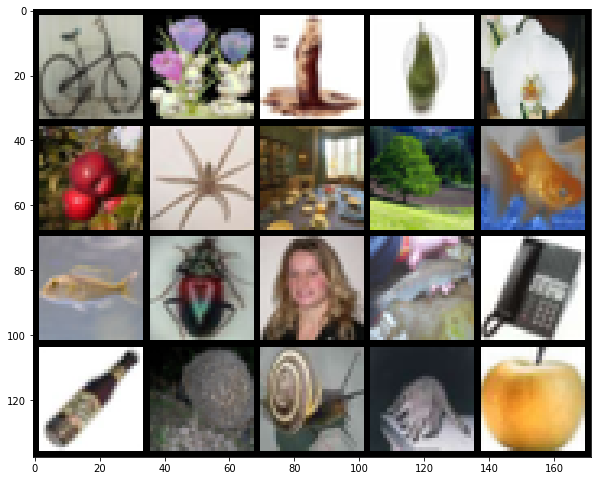

In [90]:
batch = get_batch(dl_train)
plot_data(batch,classes)

##### Treino

In [91]:
num_epochs = 50

###### Nosso Modelo

In [92]:
fit(cnn,dl_train,num_epochs = num_epochs,steps = 1000)

Epoch:  [1/50]: Loss : 4.211688667297364 Step: 1000


KeyboardInterrupt: ignored

In [ ]:
torch.save(cnn,'cnn_nn.pkl')

###### LeNet

In [ ]:
fit(lenet,dl_train,num_epochs = num_epochs,steps = 1000)

In [ ]:
torch.save(lenet,'lenet_nn.pkl')

###### AlexNet

In [ ]:
fit(alexnet,dl_train,num_epochs = num_epochs,steps = 1000)

In [ ]:
torch.save(alexnet,'alexnet_nn.pkl')

##### Salvando os Modelos

In [ ]:
torch.save(cnn,'cnn_nn.pkl')
torch.save(lenet,'lenet_nn.pkl')
torch.save(alexnet,'alexnet_nn.pkl')

#export_to_onnx(model,num_epochs = 1,steps = 500)

##### Test

###### Carregando os Modelos

In [ ]:
cnn = torch.load('cnn_nn.pkl')
lenet = torch.load('lenet_nn.pkl')
alexnet = torch.load('alexnet_nn.pkl')

###### Nosso Modelo

In [ ]:
test(cnn,dl_test) 

###### LeNet

In [ ]:
test(lenet,dl_test)

###### AlexNet

In [ ]:
test(alexnet,dl_test)

##### Métricas de Desempenho

###### Nosso Modelo

In [ ]:
y_pred = predict(cnn,ds_test)
y_test = [label for image,label in ds_test]
print(classification_report(y_test,y_pred,target_names = classes))

###### LeNet

In [ ]:
y_pred = predict(lenet,ds_test)
y_test = [label for image,label in ds_test]
print(classification_report(y_test,y_pred,target_names = classes))

###### AlexNet

In [ ]:
y_pred = predict(alexnet,ds_test)
y_test = [label for image,label in ds_test]
print(classification_report(y_test,y_pred,target_names = classes))